<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BVitoria%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/vitoriadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,23536.0,23536.000000,10406.000000,10446.000000,10443.000000,11965.000000,12072.000000,9999.000000,9485.000000,7578.000000,0.0
mean,83648.0,568.439837,3.558879,28.924076,21.865585,6.097651,3.367023,24.817622,77.470643,3.695322,NaN
std,0.0,599.182118,11.586154,3.166420,2.227757,3.558891,1.619115,2.417500,7.632188,1.780058,NaN
min,83648.0,0.000000,0.000000,18.000000,14.400000,0.000000,0.100000,16.200000,42.300000,0.000000,NaN
25%,83648.0,0.000000,0.000000,26.700000,20.200000,2.900000,2.200000,23.020000,71.750000,2.300000,NaN
50%,83648.0,0.000000,0.000000,29.000000,22.000000,7.100000,3.100000,24.860000,77.000000,3.633333,NaN
75%,83648.0,1200.000000,1.400000,31.400000,23.600000,9.200000,4.300000,26.820000,83.000000,5.033333,NaN
max,83648.0,1200.000000,305.400000,39.600000,28.400000,12.200000,18.900000,31.400000,96.750000,11.108000,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83648,1980-01-01,0,NaN,31.8,NaN,0.3,3.3,24.60,93.75,5.566667,NaN
1,83648,1980-01-01,1200,0.5,NaN,21.3,NaN,NaN,NaN,NaN,NaN,NaN
2,83648,1980-01-02,0,NaN,21.9,NaN,0.0,1.9,20.24,95.25,5.300000,NaN
3,83648,1980-01-02,1200,54.6,NaN,19.4,NaN,NaN,NaN,NaN,NaN,NaN
4,83648,1980-01-03,0,NaN,25.4,NaN,3.7,0.4,22.20,90.25,4.533333,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,10446.000000,0.0,11965.000000,12072.000000,9999.000000,9485.000000,7578.000000
mean,NaN,28.924076,NaN,6.097651,3.367023,24.817622,77.470643,3.695322
std,NaN,3.166420,NaN,3.558891,1.619115,2.417500,7.632188,1.780058
min,NaN,18.000000,NaN,0.000000,0.100000,16.200000,42.300000,0.000000
25%,NaN,26.700000,NaN,2.900000,2.200000,23.020000,71.750000,2.300000
50%,NaN,29.000000,NaN,7.100000,3.100000,24.860000,77.000000,3.633333
75%,NaN,31.400000,NaN,9.200000,4.300000,26.820000,83.000000,5.033333
max,NaN,39.600000,NaN,12.200000,18.900000,31.400000,96.750000,11.108000


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,10406.000000,0.0,10443.000000,0.0,0.0,0.0,0.0,0.0
mean,3.558879,NaN,21.865585,NaN,NaN,NaN,NaN,NaN
std,11.586154,NaN,2.227757,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,14.400000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,20.200000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,22.000000,NaN,NaN,NaN,NaN,NaN
75%,1.400000,NaN,23.600000,NaN,NaN,NaN,NaN,NaN
max,305.400000,NaN,28.400000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,31.8,0.3,3.3,24.60,93.75,5.566667
1980-01-02,21.9,0.0,1.9,20.24,95.25,5.300000
1980-01-03,25.4,3.7,0.4,22.20,90.25,4.533333
1980-01-04,27.1,8.2,2.9,23.98,92.00,3.700000
1980-01-05,27.0,10.3,3.3,24.34,93.00,3.533333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,0.5,21.3
1980-01-02,54.6,19.4
1980-01-03,31.0,18.4
1980-01-04,0.0,20.8
1980-01-05,0.0,21.6


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.8,0.3,3.3,24.60,93.75,5.566667,0.5,21.3
1980-01-02,21.9,0.0,1.9,20.24,95.25,5.300000,54.6,19.4
1980-01-03,25.4,3.7,0.4,22.20,90.25,4.533333,31.0,18.4
1980-01-04,27.1,8.2,2.9,23.98,92.00,3.700000,0.0,20.8
1980-01-05,27.0,10.3,3.3,24.34,93.00,3.533333,0.0,21.6


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,10446.000000,11965.000000,12072.000000,9999.000000,9485.000000,7578.000000,10406.000000,10443.000000
mean,28.924076,6.097651,3.367023,24.817622,77.470643,3.695322,3.558879,21.865585
std,3.166420,3.558891,1.619115,2.417500,7.632188,1.780058,11.586154,2.227757
min,18.000000,0.000000,0.100000,16.200000,42.300000,0.000000,0.000000,14.400000
25%,26.700000,2.900000,2.200000,23.020000,71.750000,2.300000,0.000000,20.200000
50%,29.000000,7.100000,3.100000,24.860000,77.000000,3.633333,0.000000,22.000000
75%,31.400000,9.200000,4.300000,26.820000,83.000000,5.033333,1.400000,23.600000
max,39.600000,12.200000,18.900000,31.400000,96.750000,11.108000,305.400000,28.400000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.8,0.3,3.3,24.60,93.75,5.566667,0.5,21.3
1980-01-02,21.9,0.0,1.9,20.24,95.25,5.300000,54.6,19.4
1980-01-03,25.4,3.7,0.4,22.20,90.25,4.533333,31.0,18.4
1980-01-04,27.1,8.2,2.9,23.98,92.00,3.700000,0.0,20.8
1980-01-05,27.0,10.3,3.3,24.34,93.00,3.533333,0.0,21.6


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,0.3,3.3,24.60,93.75,5.566667,0.5,21.3
1980-01-02,0.0,1.9,20.24,95.25,5.300000,54.6,19.4
1980-01-03,3.7,0.4,22.20,90.25,4.533333,31.0,18.4
1980-01-04,8.2,2.9,23.98,92.00,3.700000,0.0,20.8
1980-01-05,10.3,3.3,24.34,93.00,3.533333,0.0,21.6


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    31.8
1980-01-02    21.9
1980-01-03    25.4
1980-01-04    27.1
1980-01-05    27.0
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,10027.000000,10142.000000,9999.000000,8926.000000,7022.000000,9695.000000,10437.000000
mean,0.013363,-0.432877,0.133898,0.276112,-0.340156,-0.976719,0.066430
std,0.582632,0.276278,0.318092,0.277704,0.322607,0.075395,0.318250
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.504132,-0.630252,-0.102632,0.072544,-0.597887,-1.000000,-0.171429
50%,0.190083,-0.462185,0.139474,0.256198,-0.357820,-1.000000,0.085714
75%,0.504132,-0.260504,0.397368,0.467401,-0.099748,-0.990832,0.314286
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(10446, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 651.3122 - mean_absolute_error: 25.2359
Epoch 2/200
 - 1s - loss: 390.1692 - mean_absolute_error: 19.4479
Epoch 3/200
 - 1s - loss: 228.7429 - mean_absolute_error: 14.7309
Epoch 4/200
 - 1s - loss: 124.0994 - mean_absolute_error: 10.6195
Epoch 5/200
 - 1s - loss: 61.3454 - mean_absolute_error: 7.1236
Epoch 6/200
 - 1s - loss: 28.5615 - mean_absolute_error: 4.5642
Epoch 7/200
 - 1s - loss: 14.8544 - mean_absolute_error: 3.1880
Epoch 8/200
 - 1s - loss: 10.8147 - mean_absolute_error: 2.7184
Epoch 9/200
 - 1s - loss: 10.0865 - mean_absolute_error: 2.6228
Epoch 10/200
 - 1s - loss: 10.2869 - mean_absolute_error: 2.6118
Epoch 11/200
 - 1s -

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.875817, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.875817 (0.030331) {'batch_size': 10, 'camadas': 2, 'units': 7}


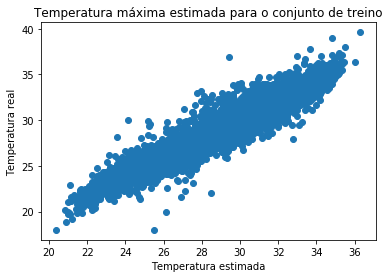

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.        0.9565891]
 [0.9565891 1.       ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

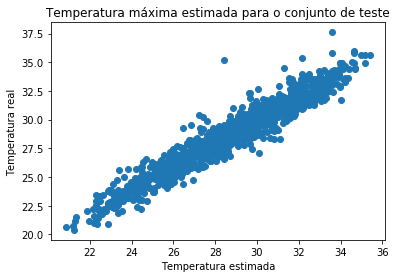

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.96127006]
 [0.96127006 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.6648250306051884


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.764525880294598


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,31.8,0.3,3.3,24.60,93.75,5.566667,0.5
1980-01-02,21.9,0.0,1.9,20.24,95.25,5.300000,54.6
1980-01-03,25.4,3.7,0.4,22.20,90.25,4.533333,31.0
1980-01-04,27.1,8.2,2.9,23.98,92.00,3.700000,0.0
1980-01-05,27.0,10.3,3.3,24.34,93.00,3.533333,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    21.3
1980-01-02    19.4
1980-01-03    18.4
1980-01-04    20.8
1980-01-05    21.6
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,10437.000000,10025.000000,10140.000000,9998.000000,8926.000000,7016.000000,9700.000000
mean,0.011675,0.013397,-0.432848,0.133900,0.275694,-0.339988,-0.976735
std,0.292998,0.582695,0.276280,0.318108,0.278028,0.322669,0.075377
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.194444,-0.504132,-0.630252,-0.102632,0.072544,-0.597887,-1.000000
50%,0.018519,0.190083,-0.462185,0.139474,0.256198,-0.357820,-1.000000
75%,0.240741,0.504132,-0.260504,0.397368,0.467401,-0.099748,-0.990832
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(10443, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 337.8495 - mean_absolute_error: 18.1297
Epoch 2/200
 - 1s - loss: 164.1178 - mean_absolute_error: 12.5398
Epoch 3/200
 - 1s - loss: 74.9093 - mean_absolute_error: 8.2985
Epoch 4/200
 - 1s - loss: 29.9466 - mean_absolute_error: 4.9504
Epoch 5/200
 - 1s - loss: 11.4210 - mean_absolute_error: 2.8254
Epoch 6/200
 - 1s - loss: 5.9932 - mean_absolute_error: 2.0307
Epoch 7/200
 - 1s - loss: 5.0498 - mean_absolute_error: 1.8802
Epoch 8/200
 - 1s - loss: 4.9664 - mean_absolute_error: 1.8652
Epoch 9/200
 - 1s - loss: 4.9673 - mean_absolute_error: 1.8652
Epoch 10/200
 - 1s - loss: 4.9628 - mean_absolute_error: 1.8647
Epoch 11/200
 - 1s - loss: 4.7301 - mean_absolute_error: 1.8178
Epoch 12/200
 - 1s - loss: 2.8907 - mean_absolute_error: 1.3766
Epoch 13/200
 - 1s - 

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.490275, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.490275 (0.017990) {'batch_size': 10, 'camadas': 2, 'units': 7}


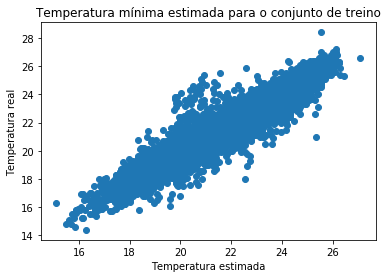

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.95057916]
 [0.95057916 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

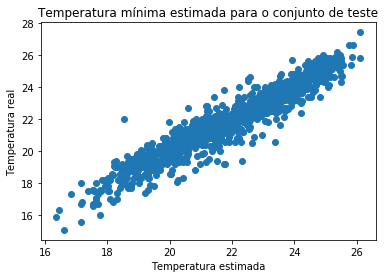

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.95244675]
 [0.95244675 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.5038583563845693


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.4464425217370346


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaVitoria.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaVitoria.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))